# Google News Scraping
In this notebook you can find the necessary code to retrieve articles for given keywords on a date range

In [1]:
from newsplease import NewsPlease
from googlesearch import search, get_tbs
import datetime
import yfinance as yf
import matplotlib.pyplot as plt
import pandas as pd
import logging

## Date interval

In [2]:
start = "2019-01-01"
end   = "2020-03-19"

## Stock prices

In [3]:
stocks = ["TSLA", "BTC-USD"]
keywords = {"TSLA": ["Tesla", "Elon Musk"],
            "BTC-USD" : ["Bitcoin", "Cryptocurrency"] }

In [4]:
df = yf.download(stocks, 
                     #period = "1Y",
                      start= start, 
                      end= end, 
                      progress=False)
df["Close"].tail()

,BTC-USD,TSLA
Date,,
2020-03-14,5200.366211,NaN
2020-03-15,5392.314941,NaN
2020-03-16,5014.479980,89.014000
2020-03-17,5225.629395,86.040001
2020-03-18,5238.438477,72.244003


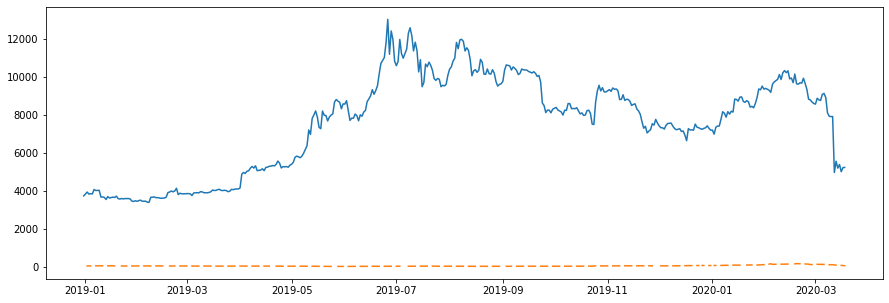

In [5]:
fig, ax = plt.subplots(figsize=(15,5))
plt.plot(df["Close"])

# Google news

In [8]:
start_date = datetime.datetime.strptime(start, "%Y-%m-%d")
end_date = datetime.datetime.strptime(end, "%Y-%m-%d")


In [10]:
tbs = get_tbs(start_date,end_date)
print(tbs)

cdr:1,cd_min:01/01/2019,cd_max:03/19/2020


In [44]:
def find_urls(search_term, tbs, number):
    results =  search(search_term ,lang = "en",tbs = tbs, country = "usa", extra_params = {"tbm" : "nws"}, stop=number)
    urls = []
    for url in results:
        urls.append(url)
    return urls

In [159]:
def download_articles(search_term, n_articles, start, end = None):
    start_date = datetime.datetime.strptime(start, "%Y-%m-%d")
    end_date = start_date if end is None else datetime.datetime.strptime(end, "%Y-%m-%d")
    tbs = get_tbs(start_date,end_date)

    urls = find_urls(search_term, tbs, 10)
    valid_articles = []
    while (len(valid_articles) < n_articles and len(urls) > 0):
        articles_left = 5 - len(valid_articles)
        articles = NewsPlease.from_urls(urls[:articles_left])
        empty, articles = detect_empty_articles(articles)
        for new in articles:
            valid_articles.append(articles.get(new))
        urls = urls[articles_left:]
    #print("valid_articles", len(valid_articles))
    return {"search_term": search_term ,"start": start, "end": start if end is None else end,"articles" : valid_articles}

    

In [174]:
def search_articles_for_each_day(search_term, start, end):
    dates = pd.date_range(start, end).format(formatter=lambda x: x.strftime('%Y-%m-%d'))
    all_entries = []
    errors = []
    for date in dates:
        try:
            articles_dict = download_articles(search_term, 5, date)
            entries = prepare_entries(articles_dict)
            all_entries.extend(entries)
        except Exception as ex:
            errors.append({"search_term" : search_term, "date" : date})
            logging.exception("Could not retrieve articles with search_term = {} for date {}".format(search_term, date))
    df = pd.DataFrame(all_entries)
    errors_df = pd.DataFrame(errors)
    return df, errors_df
    

    
    

In [183]:
def search_articles_for_keywords(keywords, start, end):
    for k in keywords:
        search_term = " | ".join(keywords.get(k))
        df, errors = search_articles_for_each_day(search_term, start, end)
        df.to_csv("./csv/{} start:{} end:{}.csv".format(search_term,start,end))
        errors.to_csv("./csv/Errors- {} start:{} end:{}.csv".format(search_term,start,end))

In [178]:
search_articles_for_keywords(keywords, "2019-01-01", "2019-01-03")

Exception in thread Thread-247:
Traceback (most recent call last):
  File "/Users/juanluisrto/anaconda3/envs/tfm/lib/python3.7/threading.py", line 926, in _bootstrap_inner
    self.run()
  File "/Users/juanluisrto/anaconda3/envs/tfm/lib/python3.7/threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "/Users/juanluisrto/anaconda3/envs/tfm/lib/python3.7/site-packages/newsplease/crawler/simple_crawler.py", line 31, in _fetch_url
    html = urllib.request.urlopen(req, data=None, timeout=timeout).read()
  File "/Users/juanluisrto/anaconda3/envs/tfm/lib/python3.7/urllib/request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "/Users/juanluisrto/anaconda3/envs/tfm/lib/python3.7/urllib/request.py", line 531, in open
    response = meth(req, response)
  File "/Users/juanluisrto/anaconda3/envs/tfm/lib/python3.7/urllib/request.py", line 641, in http_response
    'http', request, response, code, msg, hdrs)
  File "/Users/juanluisrto/anacon

In [32]:
articles[0].get_dict()

{'authors': ['Danielle Wiener-Bronner', 'Cnn Business'],
 'date_download': datetime.datetime(2020, 3, 19, 12, 40, 30),
 'date_modify': None,
 'date_publish': datetime.datetime(2019, 10, 4, 13, 19, 47),
 'description': "McDonald's McRib is back again.",
 'filename': 'https%3A%2F%2Fwww.cnn.com%2F2019%2F10%2F04%2Fbusiness%2Fmcdonalds-mcribs-returns%2Findex.html.json',
 'image_url': 'https://cdn.cnn.com/cnnnext/dam/assets/191004090608-mcdonalds-meal-bag-file-super-tease.jpg',
 'language': 'en',
 'localpath': None,
 'maintext': None,
 'source_domain': 'www.cnn.com',
 'text': None,
 'title': "The McRib is back. Here's why McDonald's doesn't sell it year-round",
 'title_page': None,
 'title_rss': None,
 'url': 'https://www.cnn.com/2019/10/04/business/mcdonalds-mcribs-returns/index.html'}